In [1]:
%load_ext autoreload
%autoreload 2
from hig_data.coco2 import COCOStuffGraphPrecomputedDataset
from hig_data.utils import DataLoader
import torch
# new_coco_val2017_hig.h5
# aug_coco_train2017_hig.h5
path = '/home/rfsm2/rds/hpc-work/datasets/coco/precomputed_coco_val_paths.json'
dataset = COCOStuffGraphPrecomputedDataset(path, swapped=False, )
from hig_data.utils import DataLoader
dls = DataLoader(dataset, batch_size=8, subsample=True)

Found 5000 complete datapoint in /home/rfsm2/rds/hpc-work/datasets/coco/coco_val2017_hig-sd.h5


In [9]:
global_variance

0.2322689926147461

In [8]:
from training.networks_edm2_hignn_inject import Precond
import torch
precond = Precond(64, 4, gnn_metadata = graph_batch.metadata(), label_dim=0)

ckpt_path = '/home/rfsm2/rds/hpc-work/training_runs/edm2_pretrained/edm2-coco256-s3_Nov_21_hr_16training-state-0016777.pt'
ckpt = torch.load(ckpt_path)


# blank_image = torch.zeros((1, 192, 32, 32))
# out, new_graph = precond.unet.enc['32x32_block0'].hignn(blank_image, dataset[0].clone())
# out.shape

!!! Passing no GRAPH !!!!
Inject version


/tmp/ipykernel_1496121/1081957871.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


In [9]:
precond.load_state_dict(ckpt['net'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['unet.enc.64x64_hignn.cond_gain', 'unet.enc.64x64_hignn.gnn.gnn_layers.0.class_node.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.0.instance_node.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.0.image_node.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.class_node__class_edge__class_node.lin_l.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.class_node__class_edge__class_node.lin_r.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.class_node__class_to_image__image_node.lin_l.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.class_node__class_to_image__image_node.lin_r.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.instance_node__instance_edge__instance_node.lin_l.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.instance_node__instance_edge__instance_node.lin_r.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.instance_node__instance_to_image__image_node.lin_l.weight', 'unet.enc.64x64_hignn.gnn.gnn_layers.1.instance_node__instance_to_image__im

In [ ]:
from training.encoders import StabilityVAEEncoder
import numpy as np

class EDM2Loss:
    def __init__(self, P_mean=-0.4, P_std=1.0, sigma_data=0.5,):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, images, graph=None, sigma=None):
        
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
        if sigma is None:
                sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        noise = torch.randn_like(images) * sigma

        denoised, logvar = net(images + noise, sigma=sigma, graph=graph, return_logvar=True)
        loss = (weight / logvar.exp()) * ((denoised - images) ** 2) + logvar
        return loss

encoder = StabilityVAEEncoder(batch_size=8)

sigmas = torch.logspace(start=torch.log10(torch.tensor(0.005)), 
                           end=torch.log10(torch.tensor(50.0)), 
                           steps=25)
loss_fn = EDM2Loss()
precond.eval()

In [ ]:




loss_over_sigma = []
with torch.no_grad():
        for sigma in sigmas:
                dataset_iterator = iter(dls)
                avg_loss = []
                for i, graph_batch in enumerate(dls):
                        if i > 4:
                                break
                        graph_batch = next(dataset_iterator).to('cuda')
                        image_latents = encoder.encode_latents(graph_batch.image.to('cuda'))
                        print(image_latents.shape)
                        graph_batch.image = image_latents
                        loss = loss_fn(net=precond.to('cuda'), images = image_latents, graph=graph_batch, sigma=sigma.to('cuda'))
                        avg_loss.append(np.mean(loss.detach().cpu().numpy()))

                avg_over = np.mean(avg_loss)
                print(sigma, avg_over)
                loss_over_sigma.append(avg_over)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import lognorm

# Plot the log space against the losses
fig, ax = plt.subplots()


# Generate log-normal distribution for overlay
mu, sigma_lognormal = 0.73, .8  # Mean and standard deviation for the log-normal distribution
# x = np.logspace(np.log10(sigmas.min()), np.log10(sigmas.max()), 100)
# log_normal = (1 / (x * sigma_lognormal * np.sqrt(2 * np.pi))) * np.exp(
#     -((np.log(x) - mu) ** 2) / (2 * sigma_lognormal ** 2)
# )
# Generate x values in the same range as your sigmas
x = np.logspace(np.log10(sigmas.min().item()), np.log10(sigmas.max().item()), 100)

# Create the log-normal distribution
dist = lognorm([sigma_lognormal], loc=0, scale=np.exp(mu))
log_normal = dist.pdf(x)

ax.plot(sigmas, loss_over_sigma, marker='o')
ax.plot(x, log_normal, label='Log-Normal Distribution', linestyle='--', color='orange')

# Set log scale and decimal formatting for x-axis
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

plt.xlabel('Logarithmic Space')
plt.ylabel('Loss')
plt.title('Logarithmic Space vs Losses')
plt.show()


In [ ]:
np.log(0.73)

In [37]:
from scipy.stats import lognorm
stddev = 0.859455801705594
mean = 0.418749176686875
dist=lognorm([stddev],loc=mean)

In [ ]:
x=np.linspace(0,6,200)
pl.plot(x,dist.pdf(x))
pl.plot(x,dist.cdf(x))

In [ ]:
np.argmin(loss_over_sigma), sigmas[13]

In [12]:
from training.networks_edm2_hignn_inject import Precond
from generate_images import edm_sampler
import os
import re
import pickle
import torch

run_dir = '/home/rfsm2/rds/hpc-work/training_runs/edm2_pretrained_xs_uncond/pretrained'
pattern=r'edm2-img512.*(\d+).pkl'
verbose=True
fnames = [entry.name for entry in os.scandir(run_dir) if entry.is_file() and re.fullmatch(pattern, entry.name)]
print(fnames)
pkl_path = os.path.join(run_dir, max(fnames, key=lambda x: float(re.fullmatch(pattern, x).group(1))))

if verbose:
    print(f'Loading from {pkl_path} ... ', end='', flush=True)
with open(pkl_path, 'rb') as f:
    data = pickle.load(f, fix_imports=True, encoding="bytes")

pretrained = data.ema

# # Extract the model state dict from the .pkl data
# model_state_dict = data.ema.state_dict()

# # filters out anything not in model_state + mismatched sizes + emb gain parameter (we want 0 cond emb gain at start of training)
# model_state_dict = {k: v for k, v in model_state_dict.items() if 'emb_label' not in k}

# # Non-strictly load the state dict into the target model
# pretrained_uncond = Precond(64, 4, gnn_metadata = dataset[0].metadata(), model_channels=128, label_dim=0)
# pretrained_uncond.load_state_dict(model_state_dict, strict=False)


['edm2-img512-xs-uncond-2147483-0.015.pkl']
Loading from /home/rfsm2/rds/hpc-work/training_runs/edm2_pretrained_xs_uncond/pretrained/edm2-img512-xs-uncond-2147483-0.015.pkl ... 

In [22]:
from training.networks_edm2_hignn_inject import Precond
from generate_images import edm_sampler
import os
import re
import pickle
import torch

run_dir = '/home/rfsm2/rds/hpc-work/training_runs/edm2_pretrained/'
# pattern=r'edm2-coco256-s3_Nov_21_hr_16-snapshot-0016777-0.050.pkl'
pattern=r'edm2-coco256-s3_Nov_21_hr_16-snapshot-0016777.*(\d+).pkl'
verbose=True
fnames = [entry.name for entry in os.scandir(run_dir) if entry.is_file() and re.fullmatch(pattern, entry.name)]
print(fnames)
pkl_path = os.path.join(run_dir, max(fnames, key=lambda x: float(re.fullmatch(pattern, x).group(1))))

if verbose:
    print(f'Loading from {pkl_path} ... ', end='', flush=True)
with open(pkl_path, 'rb') as f:
    data = pickle.load(f, fix_imports=True, encoding="bytes")

trained = data.ema

['edm2-coco256-s3_Nov_21_hr_16-snapshot-0016777-0.100.pkl', 'edm2-coco256-s3_Nov_21_hr_16-snapshot-0016777-0.050.pkl']
Loading from /home/rfsm2/rds/hpc-work/training_runs/edm2_pretrained/edm2-coco256-s3_Nov_21_hr_16-snapshot-0016777-0.100.pkl ... 

In [31]:
from generate_images import edm_sampler

graph_batch = next(iter(dls))
sample_shape = (8, 4, 64, 64)
noise = torch.randn(sample_shape, device='cuda')
# sampled = edm_sampler(net=trained.to(noise.device), gnet=pretrained.to(noise.device), noise=noise, graph=graph_batch, num_steps=64, guidance=1.9) # sample images from noise and graph batch
sampled = edm_sampler(net=trained.to(noise.device), noise=noise, graph=graph_batch, num_steps=64,) # samp
# sampled = edm_sampler(net=data.ema.to(noise.device), noise=noise, graph=graph_batch, num_steps=64,) # samp

TypeError: UNet.forward() got an unexpected keyword argument 'graph'

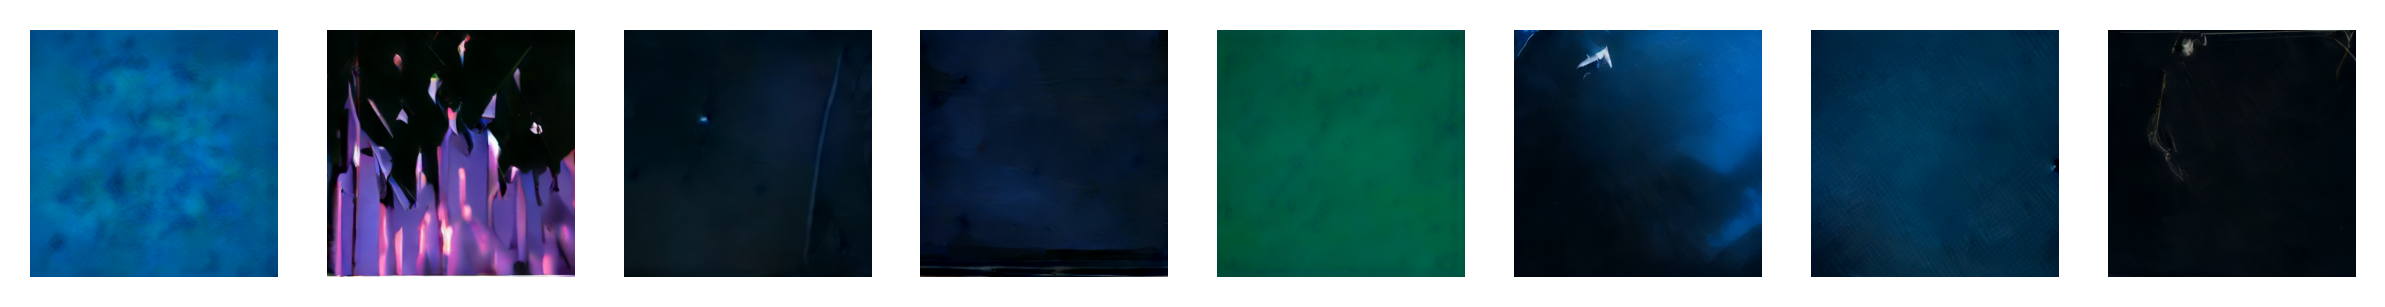

In [30]:
from hig_data.visualisation import plot_array_images
from training.encoders import StabilityVAEEncoder
# graph_batch = next(iter(dls))
vae = StabilityVAEEncoder(batch_size=8)
# print(graph_batch.image.shape, sampled.shape)
# ground_truth = vae.decode(vae.encode_latents(graph_batch.image.to('cuda')))
sampled_pixels = vae.decode(sampled.to('cuda'))
plot_array_images(sampled_pixels.cpu()) 
# plot_array_images(ground_truth.cpu()) 

In [3]:
pretrained_uncond.unet.init_control_weights()

In [4]:
from generate_images import edm_sampler

graph_batch = next(iter(dls))
sample_shape = (8, 4, 64, 64)
noise = torch.randn(sample_shape, device='cuda')
# sampled = edm_sampler(net=precond.to(noise.device), gnet=pretrained_uncond.to(noise.device), noise=noise, graph=graph_batch, num_steps=64, guidance=1.1) # sample images from noise and graph batch
sampled = edm_sampler(net=pretrained_uncond.to(noise.device), noise=noise, graph=graph_batch, num_steps=64,) # samp
# sampled = edm_sampler(net=data.ema.to(noise.device), noise=noise, graph=graph_batch, num_steps=64,) # samp

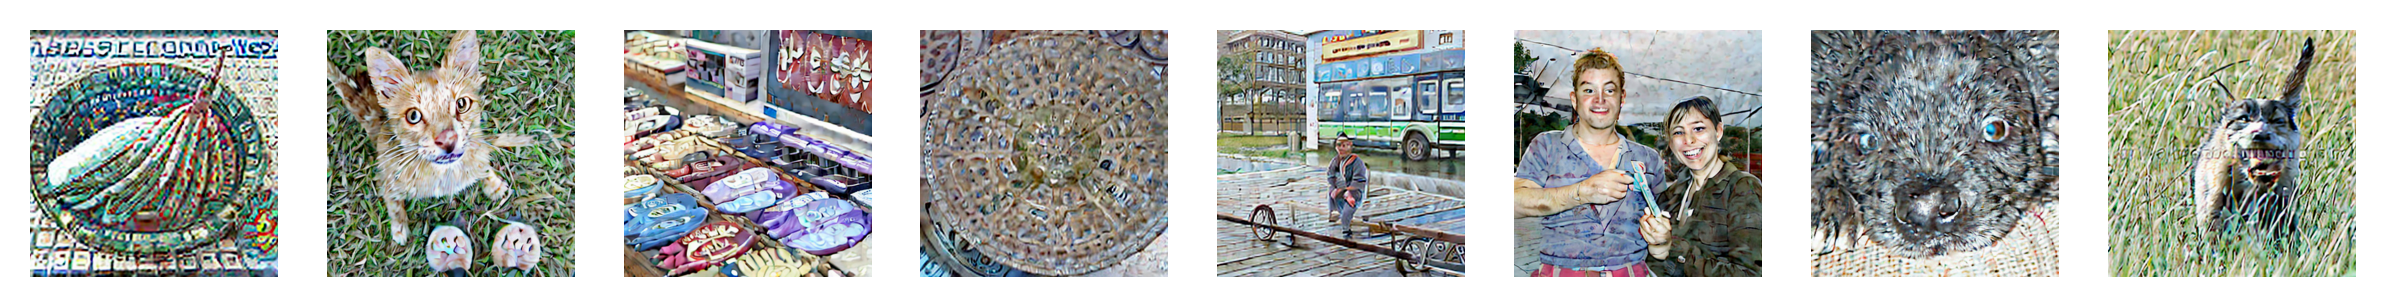

In [5]:
from hig_data.visualisation import plot_array_images
from training.encoders import StabilityVAEEncoder
# graph_batch = next(iter(dls))
vae = StabilityVAEEncoder(batch_size=8)
# print(graph_batch.image.shape, sampled.shape)
# ground_truth = vae.decode(vae.encode_latents(graph_batch.image.to('cuda')))
sampled_pixels = vae.decode(sampled.to('cuda'))
plot_array_images(sampled_pixels.cpu()) 
# plot_array_images(ground_truth.cpu()) 

In [ ]:
from generate_images import edm_sampler

graph_batch = next(iter(dls))
sample_shape = (8, 4, 64, 64)
noise = torch.randn(sample_shape, device='cuda')
# sampled = edm_sampler(net=precond.to(noise.device), gnet=pretrained_uncond.to(noise.device), noise=noise, graph=graph_batch, num_steps=64, guidance=1.1) # sample images from noise and graph batch
# sampled = edm_sampler(net=pretrained_uncond.to(noise.device), noise=noise, graph=None, num_steps=64,) # samp
sampled = edm_sampler(net=pretrained_uncond.to(noise.device), noise=noise, graph=graph_batch, num_steps=64,) # samp

In [ ]:
from hig_data.visualisation import plot_array_images
from training.encoders import StabilityVAEEncoder
# graph_batch = next(iter(dls))
vae = StabilityVAEEncoder(batch_size=8)
# print(graph_batch.image.shape, sampled.shape)
# ground_truth = vae.decode(vae.encode_latents(graph_batch.image.to('cuda')))
sampled_pixels = vae.decode(sampled.to('cuda'))
plot_array_images(sampled_pixels.cpu()) 
# plot_array_images(ground_truth.cpu()) 

In [ ]:
from torch.optim import Adam
optimizer_kwargs = dict(betas=(0.9, 0.99), lr=1e-2)
net = pretrained_uncond
new_params = [param for name, param in net.named_parameters() if 'hignn' in name]
pretrained_params = [param for name, param in net.named_parameters() if 'hignn' not in name]

optimizer = Adam(params=[{"params": pretrained_params, "lr": 1e-5}, {"params": new_params,}], **optimizer_kwargs)
optimizer.param_groups[0]['lr']